<a href="https://colab.research.google.com/github/annykay/AppliedStatistics/blob/main/seminar3/seminar03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measure quality of a classification model

This notebook explains how to measure quality of a classification machine learning model.
We provide definitions for various quality measures and try to find out if they are suitable or not for a particular machine learning classification problem.

The data is a subsample from the kaggle comptetion "Give me some credit"
https://www.kaggle.com/c/GiveMeSomeCredit#description

In [1]:
# Imports

# data processing tools: pandas and numpy
import numpy as np
import pandas as pd

# visualization tools: matplotlib, seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning tools: various methods from scikit-learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics import f1_score, accuracy_score, average_precision_score

# Load data

In [2]:
# load the data
training_data = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2022_seminars/master/seminar3/credit/training_data.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2022_seminars/master/seminar3/credit/test_data.csv')

See some technical info about data

In [3]:
# print information about the data
training_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      5001 non-null   int64  
 1   RevolvingUtilizationOfUnsecuredLines  5001 non-null   float64
 2   age                                   5001 non-null   int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  5001 non-null   int64  
 4   DebtRatio                             5001 non-null   float64
 5   MonthlyIncome                         4031 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       5001 non-null   int64  
 7   NumberOfTimes90DaysLate               5001 non-null   int64  
 8   NumberRealEstateLoansOrLines          5001 non-null   int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  5001 non-null   int64  
 10  NumberOfDependents                    4859 non-null   float64
dtypes: float64(4), in

Let's look at some general statistics of data:
* **count** -- number of not `NaN` values;
* **mean**, **std** -- mean and standard deviation;
* other -- minimal, maximal values, quantiles.

In [4]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,5001.0,0.060988,0.239332,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,5001.0,3.842957,117.415101,0.0,0.030053,0.163463,0.556134,6324.0
age,5001.0,52.128374,14.907257,21.0,41.000000,52.000000,63.000000,99.0
NumberOfTime30-59DaysPastDueNotWorse,5001.0,0.355729,3.178306,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,5001.0,368.032252,2593.676885,0.0,0.177007,0.365727,0.829553,168835.0
MonthlyIncome,4031.0,6554.690151,7058.453424,0.0,3454.500000,5333.000000,8167.500000,208333.0
NumberOfOpenCreditLinesAndLoans,5001.0,8.383323,5.111950,0.0,5.000000,8.000000,11.000000,46.0
NumberOfTimes90DaysLate,5001.0,0.194361,3.132956,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,5001.0,1.022795,1.107556,0.0,0.000000,1.000000,2.000000,17.0
NumberOfTime60-89DaysPastDueNotWorse,5001.0,0.165167,3.111899,0.0,0.000000,0.000000,0.000000,98.0


Choose randomly ten objects from dataset:

In [5]:
training_data.sample(10, random_state=123)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
2648,0,0.000000,57,0,0.000000,8500.0,3,0,0,0,3.0
2456,0,0.265081,32,0,0.207063,6200.0,6,0,0,0,3.0
4558,0,0.067098,34,0,0.280673,8500.0,7,0,2,0,2.0
4885,0,1.123876,26,1,0.356159,2540.0,5,3,0,3,2.0
92,0,0.784836,52,0,2662.000000,NaN,10,0,2,1,0.0
3602,0,0.004000,70,0,0.169479,8000.0,8,0,1,0,1.0
30,0,0.704074,28,1,0.155201,4200.0,8,0,0,0,0.0
1746,0,0.142398,57,0,0.264080,4225.0,6,0,1,0,0.0
1692,0,0.016862,48,0,0.425822,12260.0,12,0,5,0,4.0
2277,1,0.935497,55,0,0.450293,6477.0,10,0,2,0,0.0


We see that there are `NaN`s in data. Let's calculate mean values of features on **training data** and fill them in instead of the missing values. We will do that both for **train** and **test**.

There are several ways to fill in skipped data:
* mean, median;
* regression predictions;
* in case of time series -- last known value,
* linear interpolation, etc.

If the number of skipped values is small, you can throw the corresponding objects away.

In [6]:
training_data["SeriousDlqin2yrs"].value_counts()

0    4696
1     305
Name: SeriousDlqin2yrs, dtype: int64

In [7]:
# fill NA values with mean training values
train_mean = training_data.mean()

training_data.fillna(train_mean, inplace=True)
test_data.fillna(train_mean, inplace=True)

print(training_data.isnull().sum())
print(test_data.isnull().sum())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


Compare train and test distributions

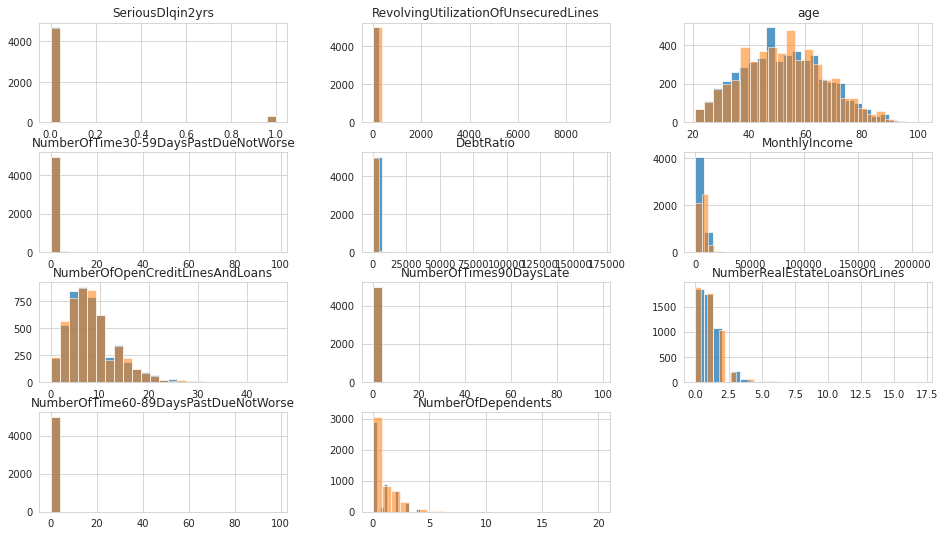

In [8]:
axes = training_data.hist(figsize=(16, 9), bins=25, alpha=0.75) # that will plot training data histograms

for plot in axes.flat: # that will draw test data on top of training histograms
    column = plot.title.get_text()
    if column:
        test_data[column].hist(ax=plot, bins=25, alpha=0.55)

Pay attention to **SeriousDlqin2yrs** -- 90 days past due delinquency or worse in the last 2 years. We see that most of the borrowers pay in time.

In [9]:
# The data set is imbalanced: typically people return credits
training_data["SeriousDlqin2yrs"].value_counts()

0    4696
1     305
Name: SeriousDlqin2yrs, dtype: int64

# Classification algorithms

First of all, load data for learning as pairs $(X, y)$, where $X = (x_i)_{i=1}^n$ -- input features,
and $y=(y_i)_{i=1}^n$ corresponding labels.

In [10]:
training_X = training_data.drop("SeriousDlqin2yrs", axis=1)
training_y = training_data["SeriousDlqin2yrs"]

test_X = test_data.drop("SeriousDlqin2yrs", axis=1)
test_y = test_data["SeriousDlqin2yrs"]

Construct calssification algorithms and train them.

In [11]:
# Construct Decision Tree model

decision_tree = DecisionTreeClassifier(max_depth = 5)
decision_tree.fit(training_X, training_y)

DecisionTreeClassifier(max_depth=5)

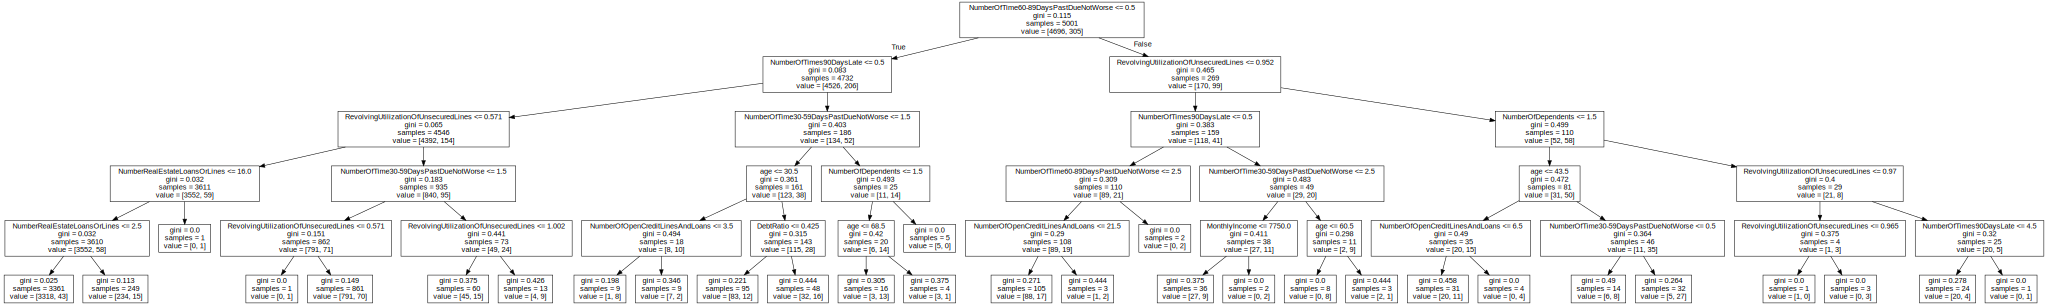

In [12]:
!pip install graphviz
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=training_X.columns))

In [13]:
# Construct k Nearest Neighbors model

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(training_X, training_y)

KNeighborsClassifier()

In [14]:
print("Training accuracy:")
print("\tDT accuracy:\t%.2f%%" % (100 * decision_tree.score(training_X, training_y)))
print("\tkNN accuracy:\t%.2f%%" % (100 * knn.score(training_X, training_y)))
print("\tNumber of '0' labels:\t%.2f%%" % (100 - 100 * np.mean(training_y)))
print()

print("Test accuracy:")
print("\tDT accuarcy:\t%.2f%%" % (100 * decision_tree.score(test_X, test_y)))
print("\tkNN accuarcy:\t%.2f%%" % (100 * knn.score(test_X, test_y)))
print("\tNumber of '0' labels:\t%.2f%%" % (100 - 100 * np.mean(test_y)))

Training accuracy:
	DT accuracy:	95.28%
	kNN accuracy:	94.10%
	Number of '0' labels:	93.90%

Test accuracy:
	DT accuarcy:	92.86%
	kNN accuarcy:	93.08%
	Number of '0' labels:	93.30%


In [15]:
test_predictions_dt = decision_tree.predict(test_X)
test_probabilities_dt = decision_tree.predict_proba(test_X)[:, 1]

training_predictions_dt = decision_tree.predict(training_X)
training_probabilities_dt = decision_tree.predict_proba(training_X)[:, 1]

In [16]:
test_predictions_knn = knn.predict(test_X)
test_probabilities_knn = knn.predict_proba(test_X)[:, 1]

training_predictions_knn = knn.predict(training_X)
training_probabilities_knn = knn.predict_proba(training_X)[:, 1]

# Classification quality measures

## Confusion matrix

Confusion matrix is table layout that allows visualization of the performance of an algorithm. Rows of this matrix correspond to actual classes of the test set, columns correspond to predicted labels. There are 4 types of elements if predictions are given:
* True Positive
* False Negative
* False Positive
* True Negative

| Variable | Predicted True | Predicted False |
| ------------- |-------------|-----|
| Actual True  | TP | FN | 
| Actual False | FP | TN |


In [17]:
confusion_dt = pd.DataFrame(confusion_matrix(test_y, test_predictions_dt))

confusion_knn = pd.DataFrame(confusion_matrix(test_y, test_predictions_knn))

print('Confusion for Decision Tree:')
print(confusion_dt)
print('Confusion for kNN:')
print(confusion_knn)

Confusion for Decision Tree:
      0   1
0  4603  63
1   294  41
Confusion for kNN:
      0   1
0  4651  15
1   331   4


If we want to compare metrics on different data, we can use instead True Positive Rate and False Positive Rate:
* False Positive Rate is $\frac{FP}{FP + TN}$
* True  Positive Rate is $\frac{TP}{TP + FN}$

## ROC curve

ROC stands for *Receiver Operating Characteristic*. This curve shows True Positive Rate (**TPR**) against False Positive Rate (**FPR**) as classifier's discrimination threshold is varied

Remember that classifiers are usually constructed based on some function
$f(x) \in [0, 1]$ and threshold $\tau$:
$$ \text{Classifier}\bigl(\text{object}\bigr)
    = \begin{cases}
    1 & \text{if}\, f(\text{object}) \geq \tau\,,\\
    0 & \text{else}\,.
    \end{cases}
$$
    
**roc_curve** function from *scikit-learn* allows to easily obtain ROC curve points and **threshold** values.

Detailed description of ROC-AUC by Alexander Dyakonov (in Russian)
https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/

In [18]:
false_positive_rates_dt, true_positive_rates_dt, threshold_dt = roc_curve(test_y, test_probabilities_dt)

false_positive_rates_knn, true_positive_rates_knn, threshold_knn = roc_curve(test_y, test_probabilities_knn)

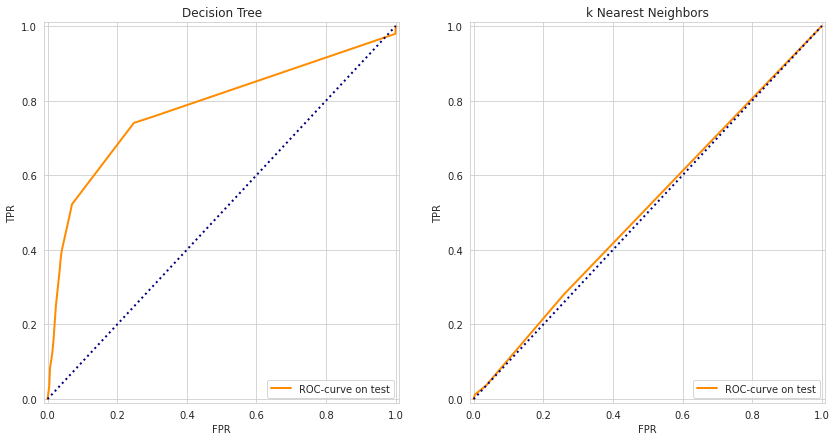

In [19]:
# create plot
fig = plt.figure(figsize=(14, 7))

# specify parameters for the first curve
plot_1 = fig.add_subplot(121,
                       xlabel="FPR", xlim=(-.01, 1.01),
                       ylabel="TPR", ylim=(-.01, 1.01), title = 'Decision Tree')

# draw the first curve
plot_1.plot(false_positive_rates_dt, true_positive_rates_dt,
          color='darkorange', lw=2, label = 'ROC-curve on test')
plot_1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.legend(loc="lower right")

# specify parameters for the second curve
plot_2 = fig.add_subplot(122,
                       xlabel="FPR", xlim=(-.01, 1.01),
                       ylabel="TPR", ylim=(-.01, 1.01), title = 'k Nearest Neighbors')

# draw the second curve
plot_2.plot(false_positive_rates_knn, true_positive_rates_knn,
          color='darkorange', lw=2, label = 'ROC-curve on test')
plot_2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.legend(loc="lower right")

plt.show()

The closer **ROC** curve to the **upper left** corner, the better classification is.

Despite being a good visual representation we usually need a number to make conclusions about calssification quality. In case of ROC curve this number is Area Under the Curve (**ROC-AUC**). 

*scikit-learn* has a special function **auc(...)**:

In [21]:
roc_auc_dt = auc(false_positive_rates_dt, true_positive_rates_dt)
roc_auc_knn = auc(false_positive_rates_knn, true_positive_rates_knn)

print("DT ROC-AUC on test data:", roc_auc_dt) 
print("kNN ROC-AUC on test data:", roc_auc_knn) 

DT ROC-AUC on test data: 0.7803481520814274
kNN ROC-AUC on test data: 0.5105027797147994


For the training set ROC curve and ROC-AUC look much better.

In [22]:
training_false_positive_rates_dt, training_true_positive_rates_dt, _ = roc_curve(training_y, training_probabilities_dt)
training_false_positive_rates_knn, training_true_positive_rates_knn, _ = roc_curve(training_y, training_probabilities_knn)

training_roc_auc_dt = auc(training_false_positive_rates_dt, training_true_positive_rates_dt)
training_roc_auc_knn = auc(training_false_positive_rates_knn, training_true_positive_rates_knn)

print("DT ROC-AUC on training data:", training_roc_auc_dt) 
print("kNN ROC-AUC on training data:", training_roc_auc_knn) 

DT ROC-AUC on training data: 0.8505512190353841
kNN ROC-AUC on training data: 0.9093846873516351


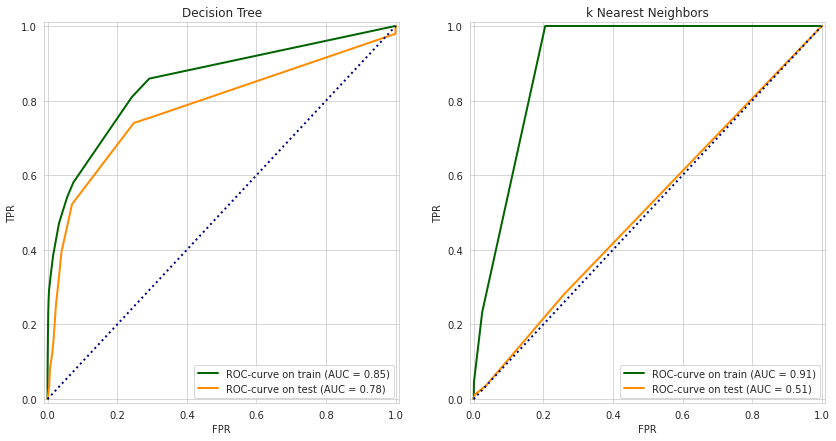

In [23]:
fig = plt.figure(figsize=(14, 7))

plot_1 = fig.add_subplot(121,
                       xlabel="FPR", xlim=(-.01, 1.01),
                       ylabel="TPR", ylim=(-.01, 1.01), title = 'Decision Tree')

# draw the first curve
plot_1.plot(training_false_positive_rates_dt, training_true_positive_rates_dt,
          color='darkgreen', lw=2, label = 'ROC-curve on train (AUC = %0.2f)' % training_roc_auc_dt)
plot_1.plot(false_positive_rates_dt, true_positive_rates_dt,
          color='darkorange', lw=2, label = 'ROC-curve on test (AUC = %0.2f)' % roc_auc_dt)
plot_1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.legend(loc="lower right")

# specify parameters for the second curve
plot_2 = fig.add_subplot(122,
                       xlabel="FPR", xlim=(-.01, 1.01),
                       ylabel="TPR", ylim=(-.01, 1.01), title = 'k Nearest Neighbors')

# draw the second curve
plot_2.plot(training_false_positive_rates_knn, training_true_positive_rates_knn,
          color='darkgreen', lw=2, label = 'ROC-curve on train (AUC = %0.2f)' % training_roc_auc_knn)
plot_2.plot(false_positive_rates_knn, true_positive_rates_knn,
          color='darkorange', lw=2, label = 'ROC-curve on test (AUC = %0.2f)' % roc_auc_knn)
plot_2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.legend(loc="lower right")

plt.show()

Another ROC-AUC visualization http://www.navan.name/roc/

Area under ROC-curve = probability of pairs of objects from different classes being classified correctly.

![alt text](https://alexanderdyakonov.files.wordpress.com/2017/07/eq.png)

$a_i$ - prediction at $i$-th object, $y_i$ - target (class), $q$- number of objects in test

## Precision and Recall

Precision and Recall are two other measures for evaluation of classification quality. Both of the metrics are calculated based on **confusion matrix**.

<img src="https://raw.githubusercontent.com/adasegroup/ML2022_seminars/main/seminar3/figures/precision_recall.png">

Note that Recall equals to True Positive Rate.

Although "accuracy" and "precision" have very similar meanings, they are completely different metrics. Look how Precision and Recall are evaluated for k Nearest Neighbors classifier:

In [24]:
confusion = confusion_matrix(test_y, test_predictions_knn)

In [25]:
TN, FP = confusion[0, 0], confusion[0, 1]
FN, TP = confusion[1, 0], confusion[1, 1]

**Recall** of a classifier is equal to True Positive Rate **TPR** ($\frac{TP}{TP + FN}$). This value may be interpreted as a sensitivity of a classifier to the objects with label `1`. If it is close to $100\%$, then a classifier rarely "miss" the object of class `1`.

In [26]:
recall = TP / (TP + FN)

print("Recall: %.2f%%" % (100 * recall))

Recall: 1.19%


**Precision** -- is a fraction $\frac{TP}{TP + FP}$. If this value is large, then a classifier assigns label `1` to objects with actual label `0` rarely.

See how it is different to Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

In [27]:
precision = TP / (TP + FP)

print("Precision: %.2f%%" % (100 * precision))

Precision: 21.05%


A classifier with large Recall but small Precision produces many false positive predictions and tends to assign many `1` labels.

Vice versa, if a classifier has small Recall but large Precision, then it detects class `1` accurately, but misses many objects (many false negative predictions).

### Precision-Recall curve

In **precision-recall** space we may construct a curve similar to **ROC** curve in **FPR-TPR** space. PR curve also depicts the dependecy of Precision and Recall on threshold. *scikit* has the corresponding function: **precision_recall_curve(...)**.

Let's calculate PR curve points.

Note that unlike ROC curve, we cannot use interpolation for calculation of area under the curve. This may lead to larger values of the metric, which is not good. In this case we need to use **average_precision_score()** function instead of **auc()** function.

In [28]:
# generate values for Precision-Recall curve
precision_dt, recall_dt, _ = precision_recall_curve(test_y, test_probabilities_dt)
precision_knn, recall_knn, _ = precision_recall_curve(test_y, test_probabilities_knn)

# calculate value under Precision-Recall curve
pr_auc_dt = average_precision_score(test_y, test_probabilities_dt)
pr_auc_knn = average_precision_score(test_y, test_probabilities_knn)

print("DT PR-AUC on test data:", pr_auc_dt) 
print("kNN PR-AUC on test data:", pr_auc_knn)

DT PR-AUC on test data: 0.26654737363117215
kNN PR-AUC on test data: 0.06997723581835391


In [29]:
# generate values for training Precision Recall curve
training_precision_dt, training_recall_dt, _ = precision_recall_curve(training_y, training_probabilities_dt)
training_precision_knn, training_recall_knn, _ = precision_recall_curve(training_y, training_probabilities_knn)

# TODO calculate value under precision-recall curve
training_pr_auc_dt = average_precision_score(training_y, training_probabilities_dt)
training_pr_auc_knn = average_precision_score(training_y, training_probabilities_knn)

print("DT PR-AUC on training data:", training_pr_auc_dt) 
print("kNN PR-AUC on training data:", training_pr_auc_knn) 

DT PR-AUC on training data: 0.46891401493347407
kNN PR-AUC on training data: 0.291291159995799


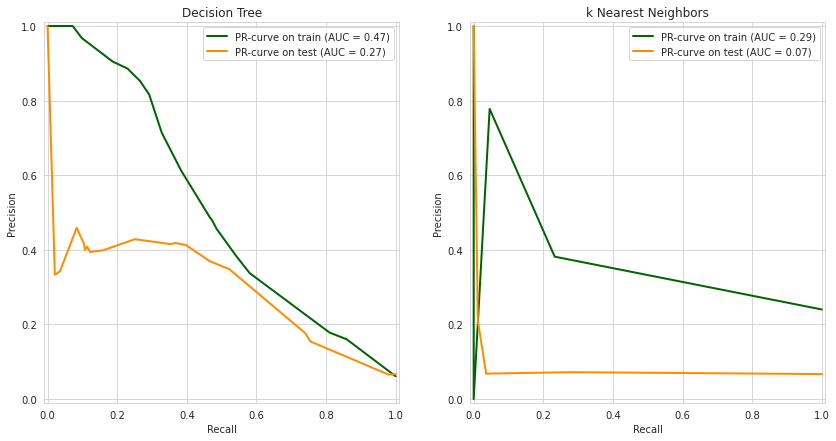

In [30]:
fig = plt.figure(figsize=(14, 7))

plot_1 = fig.add_subplot(121,
                       xlabel="Recall", xlim=(-.01, 1.01),
                       ylabel="Precision", ylim=(-.01, 1.01), title = 'Decision Tree')

plot_1.plot(training_recall_dt, training_precision_dt,
          color='darkgreen', lw=2, label = 'PR-curve on train (AUC = %0.2f)' % training_pr_auc_dt)
plot_1.plot(recall_dt, precision_dt,
          color='darkorange', lw=2, label = 'PR-curve on test (AUC = %0.2f)' % pr_auc_dt)
plt.legend(loc="upper right")


plot_2 = fig.add_subplot(122,
                       xlabel="Recall", xlim=(-.01, 1.01),
                       ylabel="Precision", ylim=(-.01, 1.01), title = 'k Nearest Neighbors')

plot_2.plot(training_recall_knn, training_precision_knn,
          color='darkgreen', lw=2, label = 'PR-curve on train (AUC = %0.2f)' % training_pr_auc_knn)
plot_2.plot(recall_knn, precision_knn,
          color='darkorange', lw=2, label = 'PR-curve on test (AUC = %0.2f)' % pr_auc_knn)
plt.legend(loc="upper right")

plt.show()

The closer **PR** curve to the **upper right** corner, the better classification is.

Large AUC value means that Precision and Recall are also large. That means that classifier makes small number of both False Positives and False Negatives.

## F1 score

This metric allows to take into account a different cost for False Positive Errors and False Negative Errors.

General $F_\beta$ score is defined as follows:
$$
F_\beta = (1 + \beta^2) \frac{Precision \cdot Recall}{\beta^2 Precision + Recall} = \frac{1 + \beta^2}{\frac{\beta^2}{Recall} + \frac{1}{Precision}}= \frac{\beta + \beta^{-1}}{\beta\frac{1}{\text{Recall}} + \beta^{-1}\frac{1}{\text{Precision}}}
    \,.
$$

Most commonly used is $F_1$ score:
$$
F_1 = 2 \frac{Precision \cdot Recall}{Precision + Recall}
$$

Harmonic mean is used in order to make metric value very small when Precision or Recall is close to zero. Note that $F_1$ score doesn't describe how classifier works for True Negative results (**TN**).

In [31]:
print("DT F1 score on training data", f1_score(training_y, training_predictions_dt))
print("kNN F1 score on training data", f1_score(training_y, training_predictions_knn))

print("DT F1 score on test data", f1_score(test_y, test_predictions_dt))
print("kNN F1 score on test data", f1_score(test_y, test_predictions_knn))

DT F1 score on training data 0.42995169082125606
kNN F1 score on training data 0.08668730650154799
DT F1 score on test data 0.1867881548974943
kNN F1 score on test data 0.022598870056497175


$F_1$ score is good for imbalanced classification, when a number of class `1` objects is **much** bigger than class `0` objects.

Let's compare **accuracy** and $F_1$ score of our classifiers with *random* classifier, which works as follows:

* estimate probability $\hat{p}$ of class `1` on training data (frequency of class `1` objects);
* for every test object predict randomly:
    * label `1` with probability $\hat{p}$,
    * label `0` with probability $1 - \hat{p}$.

In [32]:
training_prob = sum(training_y) / len(training_y)
random_predictions = np.random.binomial(1, training_prob, len(test_y))

In [33]:
print("Decision Tree accuracy\t\t", accuracy_score(test_y, test_predictions_dt))
print("kNN accuracy\t\t\t", accuracy_score(test_y, test_predictions_knn))
print("Random classifier accuracy\t", accuracy_score(test_y, random_predictions))
print('---')
print("Decision Tree F1 score\t\t", f1_score(test_y, test_predictions_dt))
print("kNN F1 score\t\t\t", f1_score(test_y, test_predictions_knn))
print("FRandom classifier F1 score\t", f1_score(test_y, random_predictions))

Decision Tree accuracy		 0.9286142771445711
kNN accuracy			 0.9308138372325535
Random classifier accuracy	 0.884623075384923
---
Decision Tree F1 score		 0.1867881548974943
kNN F1 score			 0.022598870056497175
FRandom classifier F1 score	 0.08846761453396525


# Exercise 1

We have seen how some of classifiers work for this dataset. Now, try it yourself with Logistic Regression.

* Fisrt, **import** **LogisticRegression()** function and train it on training data.
* Then, calculate **ROC AUC**, **PR AUC** and **F1 score** on test data.
* Try to change parameters to improve results.

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [38]:
from sklearn.linear_model import LogisticRegression

logReg =  LogisticRegression(max_iter = 500)
logReg.fit(training_X, training_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=500)

In [40]:
test_predictions_lr = logReg.predict(test_X)
test_probabilities_lr = logReg.predict_proba(test_X)[:, 1]

training_predictions_lr = logReg.predict(training_X)
training_probabilities_lr = logReg.predict_proba(training_X)[:, 1]

training_false_positive_rates_lr, training_true_positive_rates_lr, _ = roc_curve(training_y, training_probabilities_lr)

training_roc_auc_lr = auc(training_false_positive_rates_lr, training_true_positive_rates_lr)


print("LR ROC-AUC on training data:", training_roc_auc_lr) 


DT ROC-AUC on training data: 0.6837385148155388


In [41]:
false_positive_rates_lr, true_positive_rates_lr, threshold_lr = roc_curve(test_y, test_probabilities_lr)


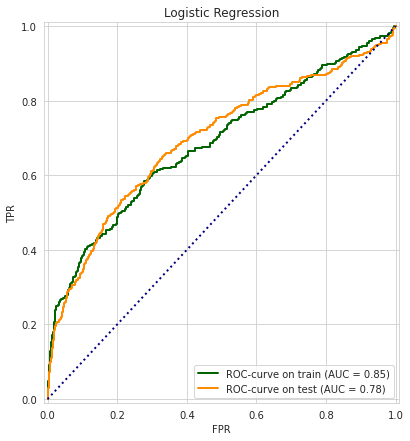

In [44]:
fig = plt.figure(figsize=(14, 7))

plot_1 = fig.add_subplot(121,
                       xlabel="FPR", xlim=(-.01, 1.01),
                       ylabel="TPR", ylim=(-.01, 1.01), title = 'Logistic Regression')

# draw the first curve
plot_1.plot(training_false_positive_rates_lr, training_true_positive_rates_lr,
          color='darkgreen', lw=2, label = 'ROC-curve on train (AUC = %0.2f)' % training_roc_auc_dt)
plot_1.plot(false_positive_rates_lr, true_positive_rates_lr,
          color='darkorange', lw=2, label = 'ROC-curve on test (AUC = %0.2f)' % roc_auc_dt)
plot_1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
plt.legend(loc="lower right")


plt.legend(loc="lower right")

plt.show()

In [45]:
# generate values for Precision-Recall curve
precision_lr, recall_lr, _ = precision_recall_curve(test_y, test_probabilities_lr)

# calculate value under Precision-Recall curve
pr_auc_lr = average_precision_score(test_y, test_probabilities_lr)

print("LR PR-AUC on test data:", pr_auc_lr) 

# generate values for training Precision Recall curve
training_precision_dt, training_recall_lr, _ = precision_recall_curve(training_y, training_probabilities_dt)
training_precision_knn, training_recall_knn, _ = precision_recall_curve(training_y, training_probabilities_knn)

# TODO calculate value under precision-recall curve
training_pr_auc_dt = average_precision_score(training_y, training_probabilities_dt)
training_pr_auc_knn = average_precision_score(training_y, training_probabilities_knn)

print("DT PR-AUC on training data:", training_pr_auc_dt) 
print("kNN PR-AUC on training data:", training_pr_auc_knn) 

LR PR-AUC on test data: 0.20858435768715797


# Cross-validation technique

In many cases test sample is not available or we have a small dataset, and we have only one sample: a training one. The most popular approach in this case is **cross-validation**.

The most common way is $k$-fold cross-validation. The idea is to divide training sample into $k$ blocks, one of them is treated as an artificial test sample and other $k-1$ are used for training.

*scikit* has several functions for dividing data into folds and for performing automated cross-validation. One of those functions is **GridSearchCV()**.

<img src="https://raw.githubusercontent.com/adasegroup/ML2022_seminars/main/seminar3/figures/5-fold-cv.png?raw=1">

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters_knn = {'n_neighbors': [5, 10, 15, 20]}
knn_cv = GridSearchCV(knn, param_grid = parameters_knn)
knn_cv.fit(training_X, training_y)

In [ ]:
knn_cv.best_params_

In [ ]:
predictions_knn_cv = knn_cv.predict(test_X)
probabilities_knn_cv = knn_cv.predict_proba(test_X)[:,1]

In [ ]:
false_positive_rates_knn_cv, true_positive_rates_knn_cv, _ = roc_curve(test_y, probabilities_knn_cv)
roc_auc_knn_cv = auc(false_positive_rates_knn_cv, true_positive_rates_knn_cv)

In [ ]:
precision_knn_cv, recall_knn_cv, _ = precision_recall_curve(test_y, probabilities_knn_cv)
pr_auc_knn_cv = average_precision_score(test_y, probabilities_knn_cv)

In [ ]:
f1_knn_cv = f1_score(test_y, predictions_knn_cv)

In [ ]:
print('ROC AUC: ', roc_auc_knn_cv)
print('PR AUC: ', pr_auc_knn_cv)
print('F1_score: ', f1_knn_cv)

In [ ]:
pd.DataFrame(confusion_matrix(test_y, predictions_knn_cv))

# Exercise 2

Now we know how to perform cross-validation. Try it yourself with Decision Tree.

* Using **GridSearchCV** choose parameter **min_samples_leaf**. Try several values from 1 to 100.
* Use **five**-fold cross-validation and **roc_auc** scoring. See the chosen parameters.
* Evaluate quality metrics and look how they changed. Try to make some plots.

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

HINT https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

# Multiclass classification

Let's have a look how multiclass tasks are treated.

In [ ]:
# import some modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
import zipfile

## Load data

We will use data from Kaggle contest *"Otto Group
Product Classification Challenge"*, which was created to predict class of an item by several features.

https://www.kaggle.com/c/otto-group-product-classification-challenge

Data are in ZIP, but we can load them easily

In [ ]:
train_dataset = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2022_seminars/master/seminar3/otto/train.csv', index_col='id')
test_dataset = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2022_seminars/master/seminar3/otto/test.cutted.csv', index_col='id')

Data consist of the following:
* **id** -- anonymized identifier;
* **feat_1, ..., feat_93** -- features;
* **target** -- actual class of an item.

Number of objects for every class in **target**

In [ ]:
train_dataset['target'].value_counts()

In [ ]:
y = train_dataset["target"]
X = np.asarray(train_dataset.drop("target", axis = 1))

Let's see data description

In [ ]:
train_dataset.describe().T

Divide data into input and output, transform labels from strings to numbers. **LabelEncoder** allows us to perform that transform nad obtain numbers from $0$ to $K-1$, where $K$ is the number of classes.

In [ ]:
import xgboost

In [ ]:
xgb = xgboost.XGBClassifier(objective='multi:softprob')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Split data into training sample and test sample

In [ ]:
split = train_test_split(X, y, test_size=0.5,
                         random_state=42, stratify=y)
train_X, test_X, train_y, test_y = split

In [ ]:
xgb.fit(train_X, train_y)

In [ ]:
test_preds = xgb.predict(test_X)

In [ ]:
accuracy_score(test_y, test_preds)

In [ ]:
confusion_matrix(test_y, test_preds)

In [ ]:
print(classification_report(test_y, test_preds))